In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
sns.set_style("whitegrid")


In [3]:
df = pd.read_csv("/content/bmw.csv")
# print(df.head())
# print(df.shape)
# print(df.info())
# print(df.isnull().sum())
# print(df.tail())
# print(df.describe())
df = df.drop_duplicates()
# print(df.duplicated().sum())

In [4]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.600,2.000
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.800,2.000
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.400,3.000
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.400,1.500
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.400,3.000


In [5]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()


In [6]:
print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)


Numerical Columns: ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']
Categorical Columns: ['model', 'transmission', 'fuelType']


In [7]:
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    "Missing Count": missing,
    "Missing %": missing_percent
})

missing_df[missing_df["Missing Count"] > 0]

,Missing Count,Missing %


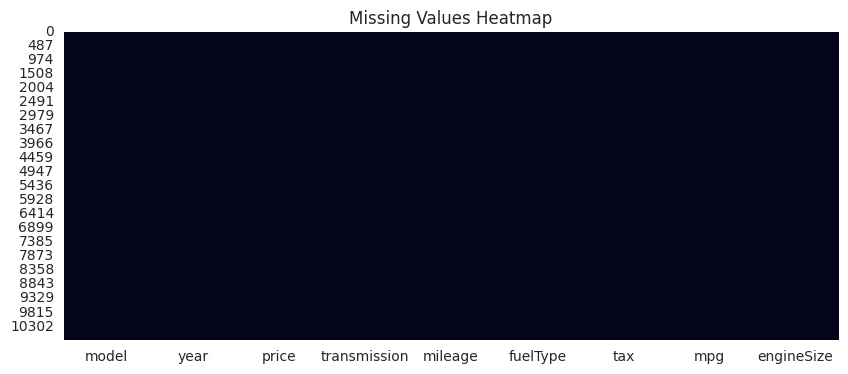

In [8]:
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()


In [9]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
year,10664.000,2017.063,2.351,1996.000,2016.000,2017.000,2019.000,2020.000
price,10664.000,22692.889,11434.921,1200.000,14897.000,20261.500,27890.000,123456.000
mileage,10664.000,25710.979,25146.635,1.000,5665.750,18783.000,38436.500,214000.000
tax,10664.000,131.597,61.611,0.000,135.000,145.000,145.000,580.000
mpg,10664.000,56.483,31.466,5.500,45.600,53.300,62.800,470.800
engineSize,10664.000,2.170,0.553,0.000,2.000,2.000,2.000,6.600


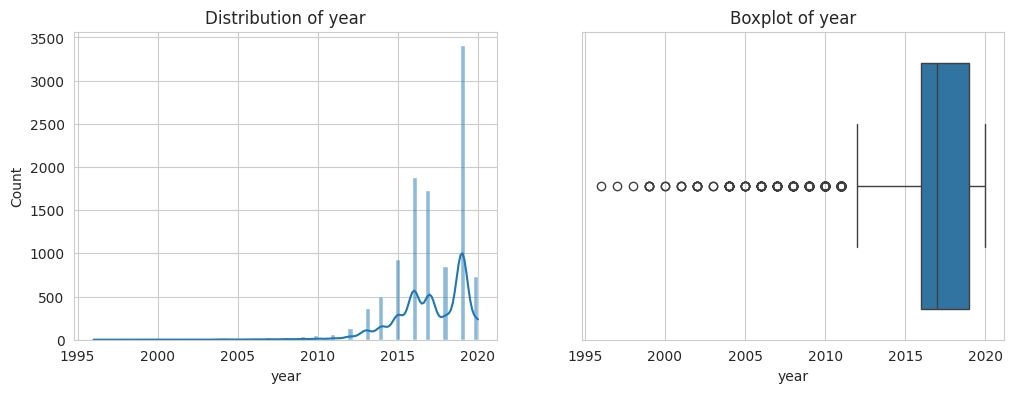

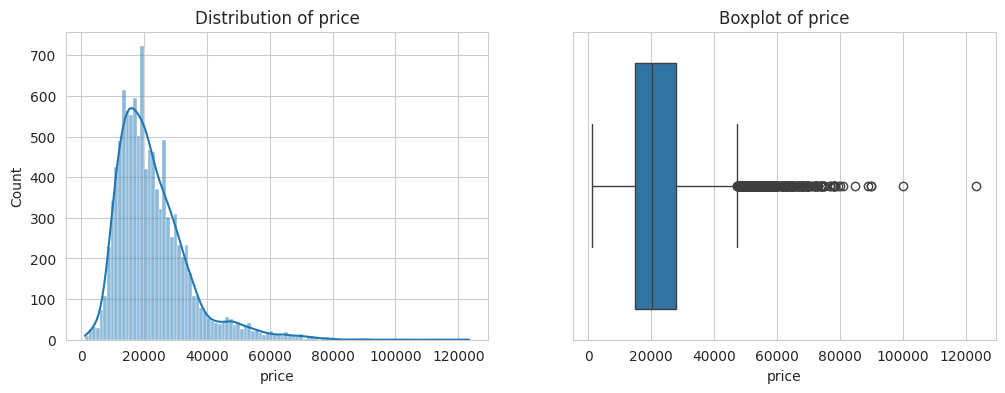

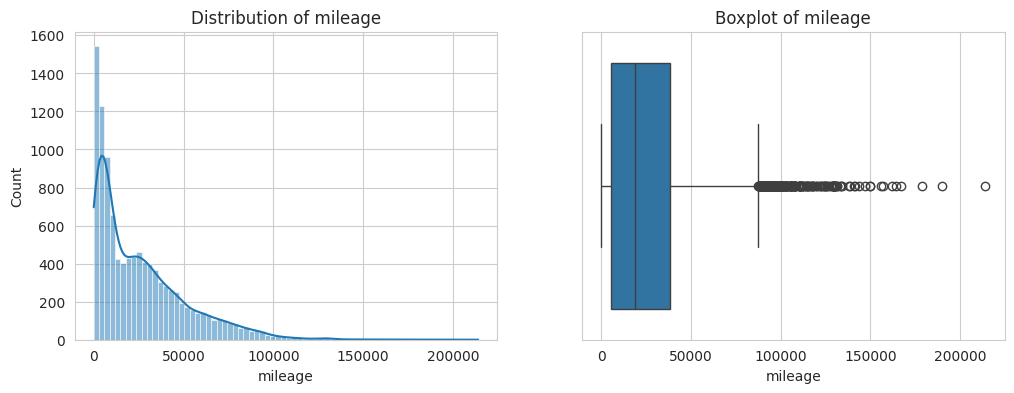

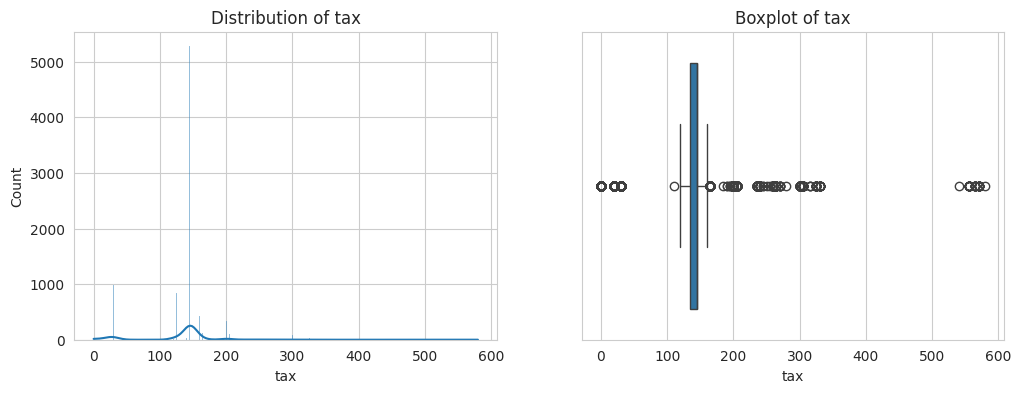

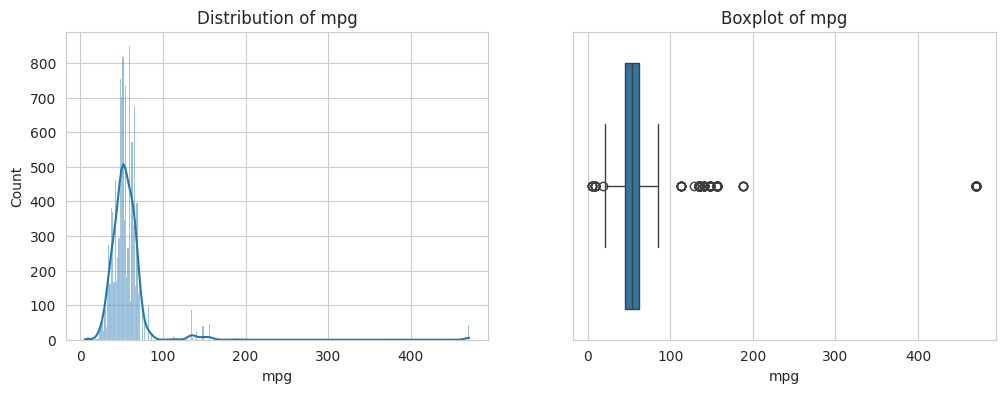

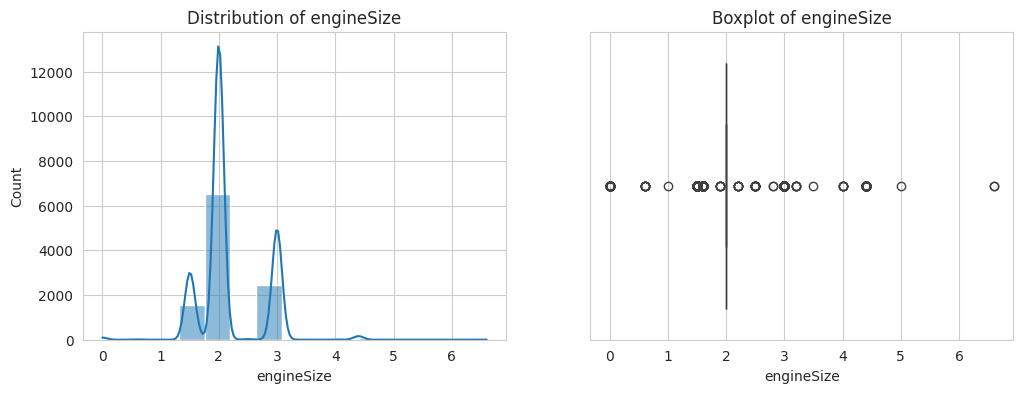

In [10]:
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")

    plt.show()

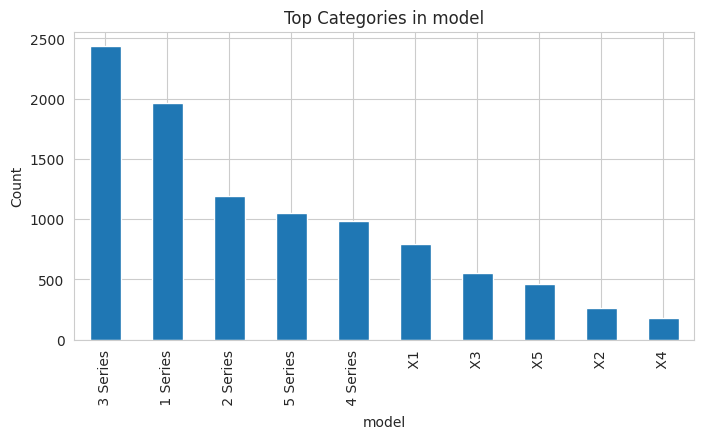

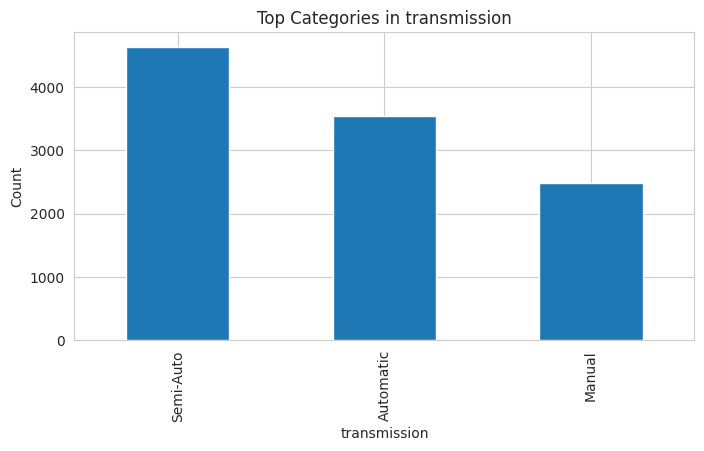

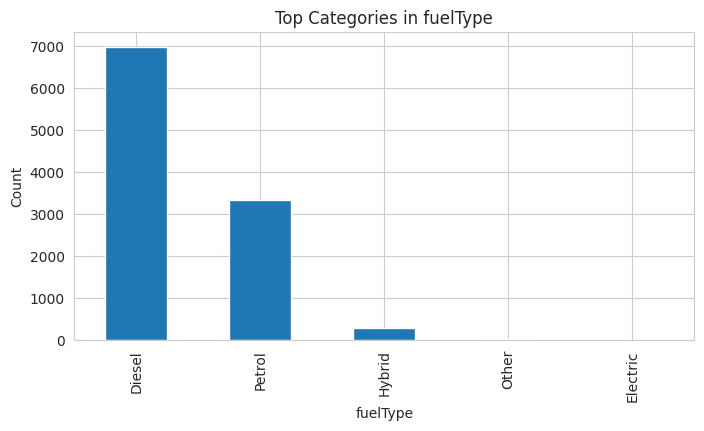

In [11]:
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    df[col].value_counts().head(10).plot(kind='bar')
    plt.title(f"Top Categories in {col}")
    plt.ylabel("Count")
    plt.show()


Top Categories

In model the Series 3 model has a higher demand in comparison to its peer models

In Transmission the Semi auto-Transmission is a demanded transmission among all three transmissions

In Fuel the Diesel Fuel is a falling out factor from other fuel types.

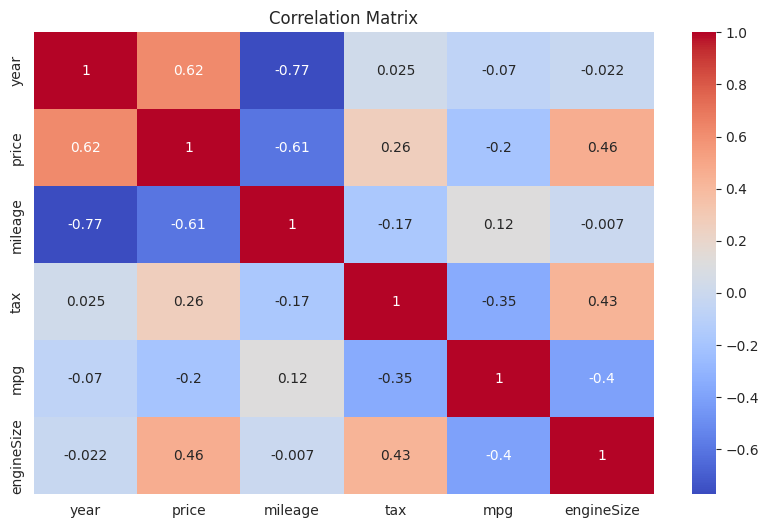

In [12]:
if len(num_cols) > 1:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

In the above correlation matrix, we get to know that the data itself not that much correlated with each. So to sum it up no column changes are done

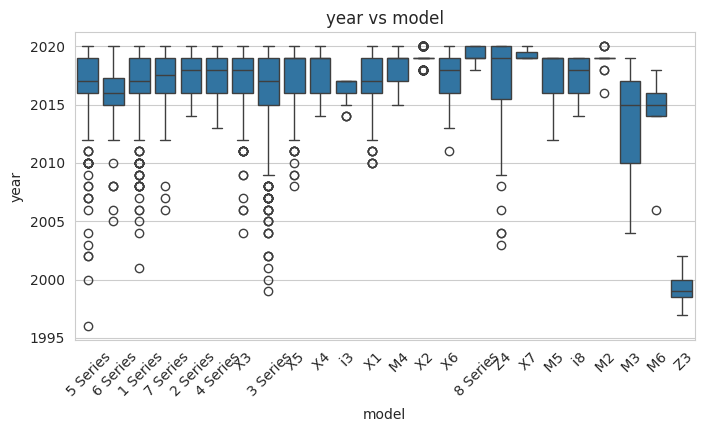

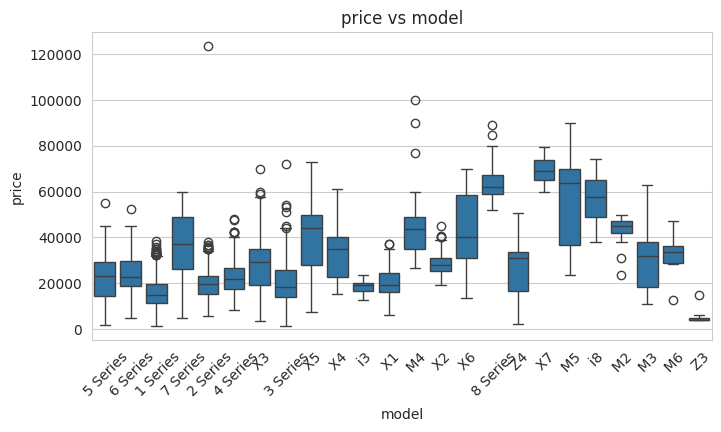

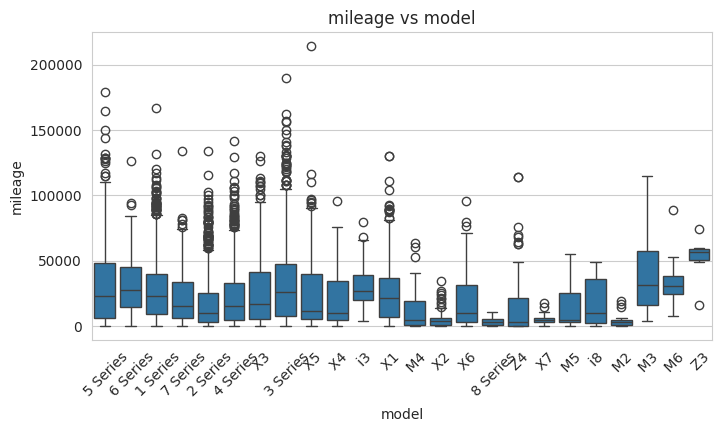

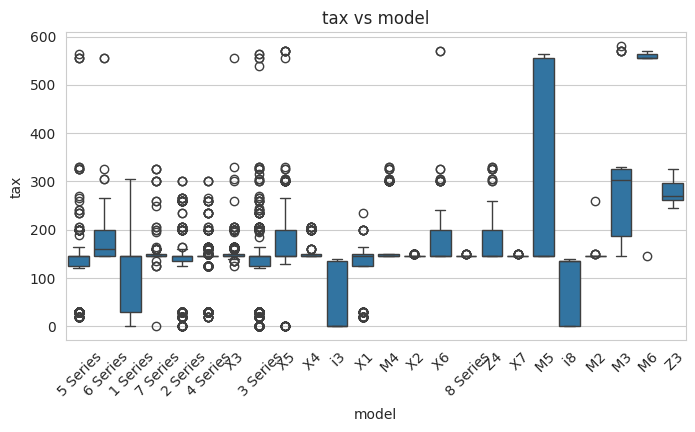

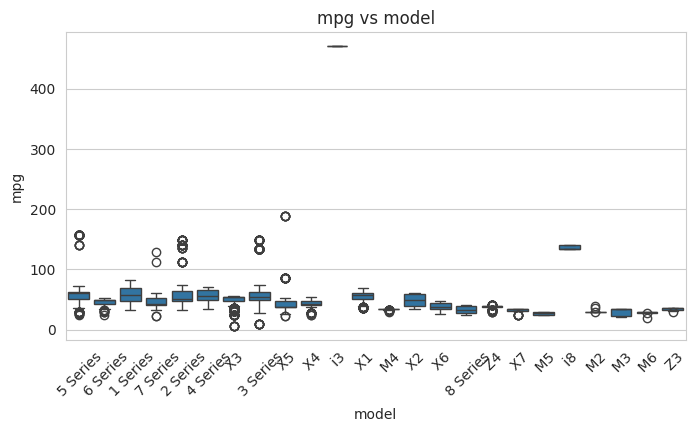

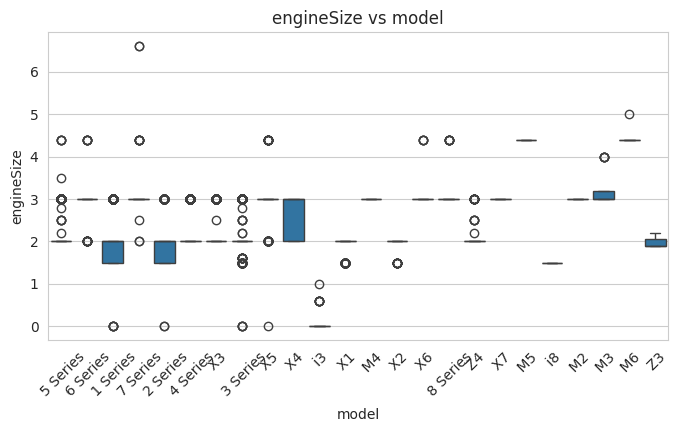

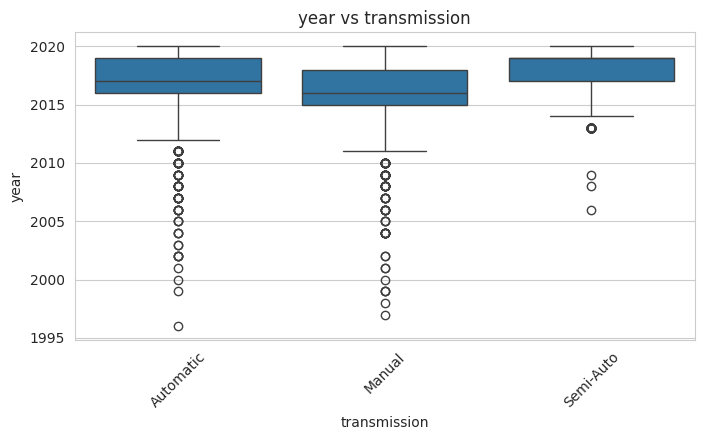

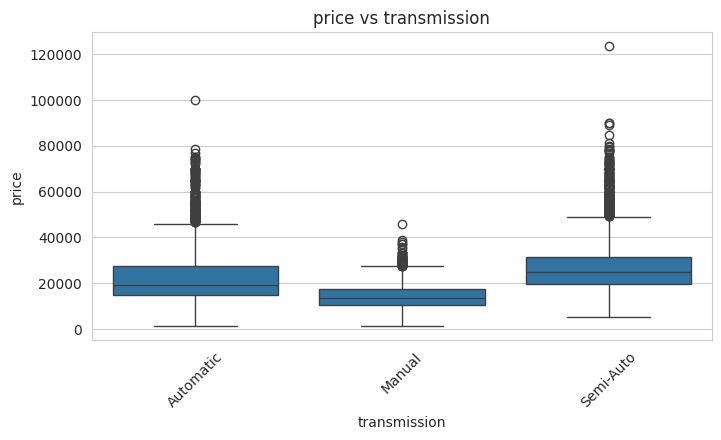

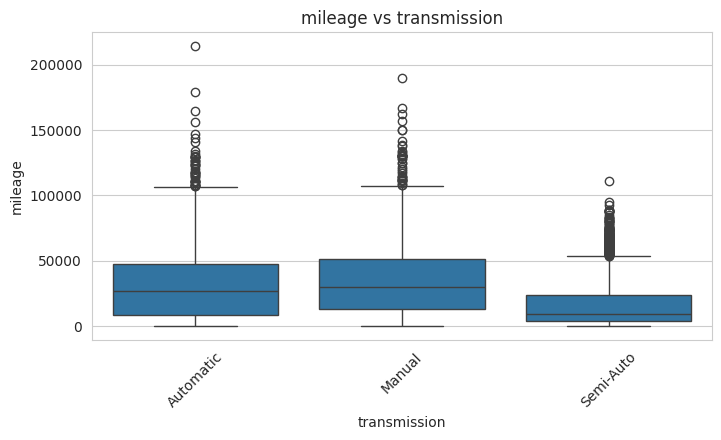

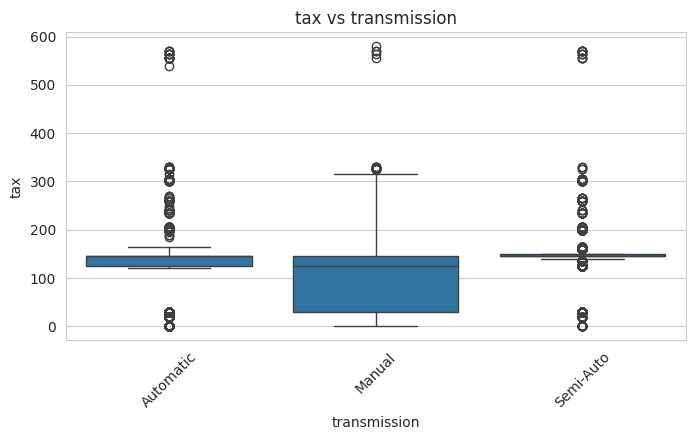

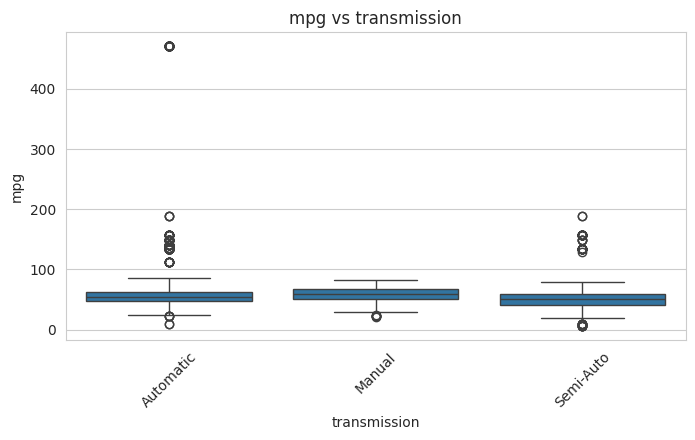

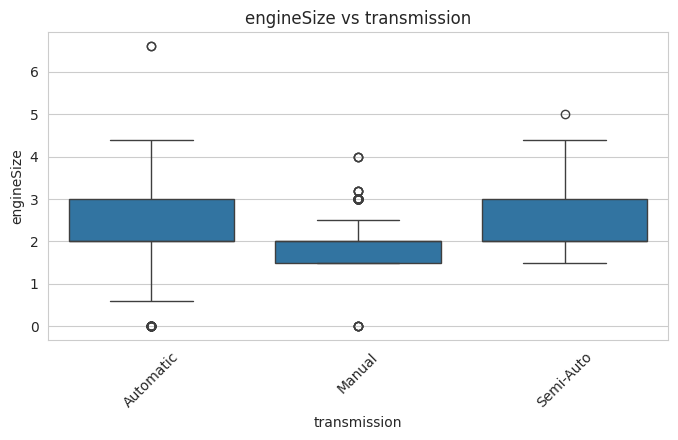

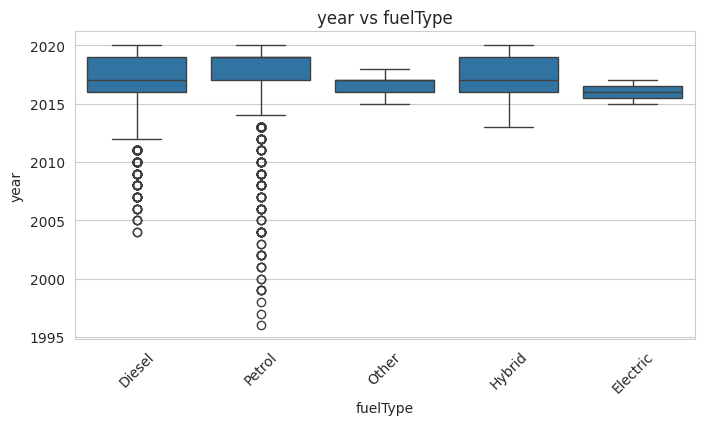

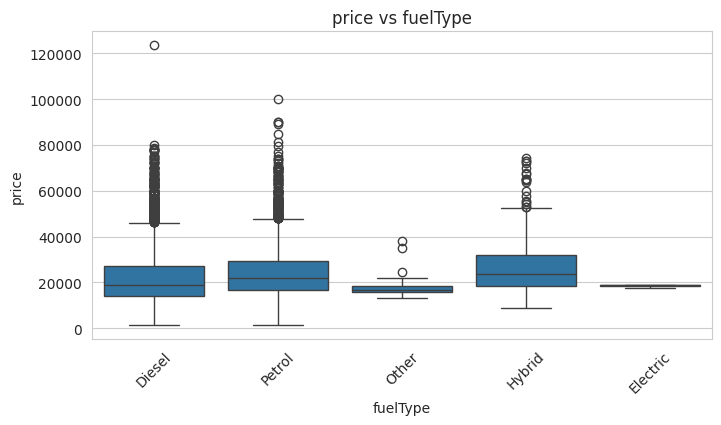

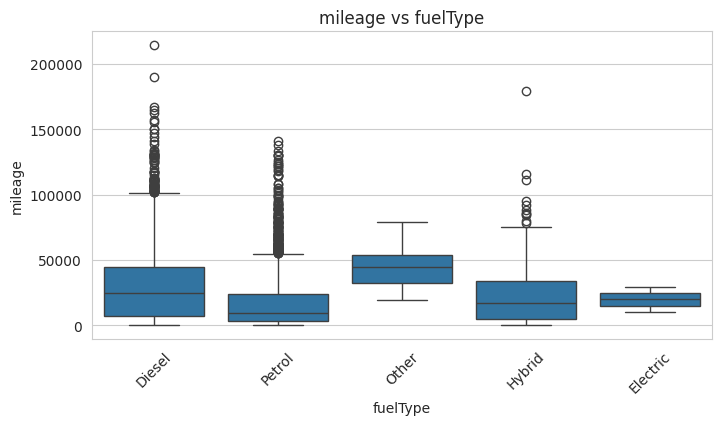

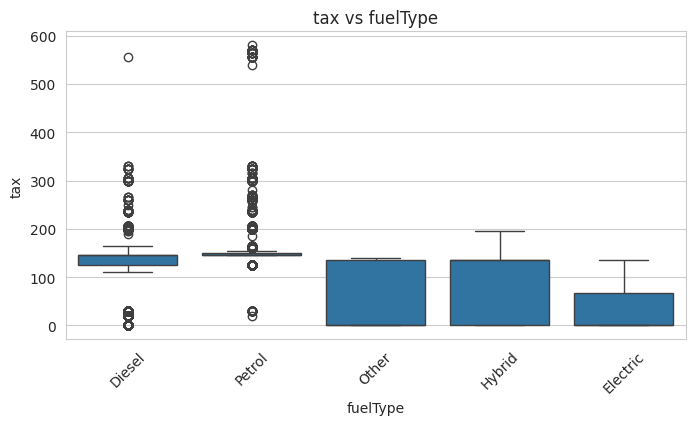

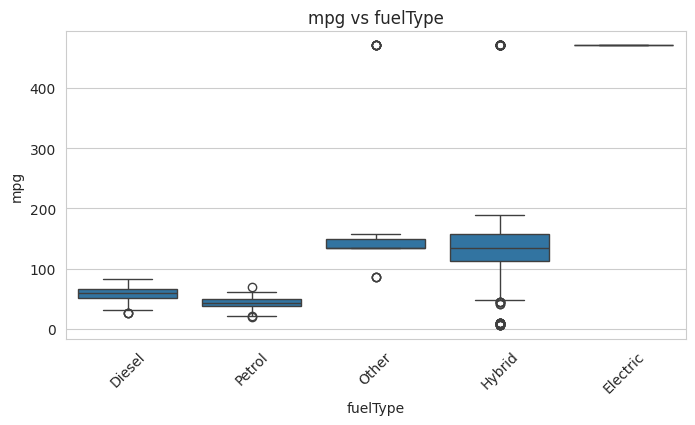

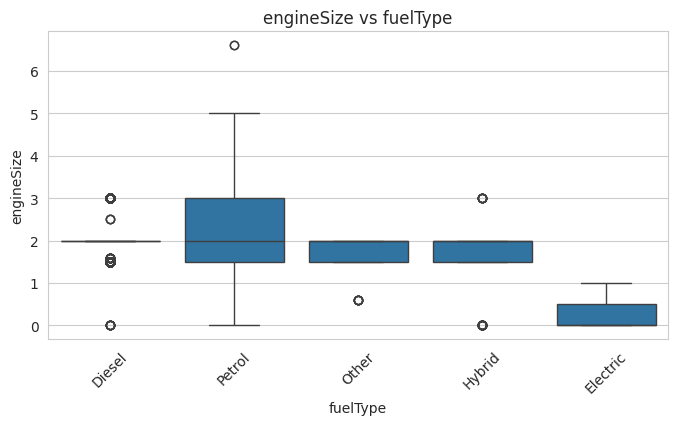

In [13]:
for cat in cat_cols:
    for num in num_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[cat], y=df[num])
        plt.title(f"{num} vs {cat}")
        plt.xticks(rotation=45)
        plt.show()

In [14]:
sns.boxplot(x=df['engineSize'], ax=axes[1])
axes[1].set_title(f"Boxplot of {'engineSize'}")
plt.show()


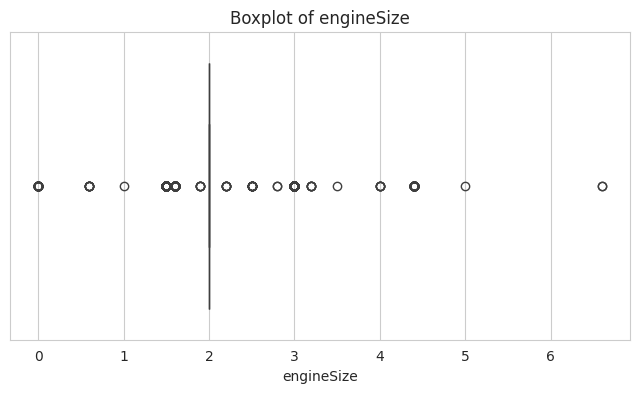

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['engineSize'])
plt.title("Boxplot of engineSize")
plt.show()

Outliers for enigineSize

The concentration of observations around an engine size of approximately 2.0 liters shows that this configuration dominates the dataset, implying it is the most preferred or standard engine size in the market.

In [16]:
outlier_summary = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    outlier_summary[col] = len(outliers)

pd.DataFrame.from_dict(outlier_summary, orient="index", columns=["Outlier Count"])

,Outlier Count
year,212
price,478
mileage,293
tax,2722
mpg,274
engineSize,4156


In [17]:
summary = {
    "rows": df.shape[0],
    "columns": df.shape[1],
    "numerical_columns": len(num_cols),
    "categorical_columns": len(cat_cols),
    "total_missing_values": df.isnull().sum().sum(),
    "duplicate_rows": df.duplicated().sum()
}

pd.DataFrame.from_dict(summary, orient="index", columns=["Value"])

,Value
rows,10664
columns,9
numerical_columns,6
categorical_columns,3
total_missing_values,0
duplicate_rows,0


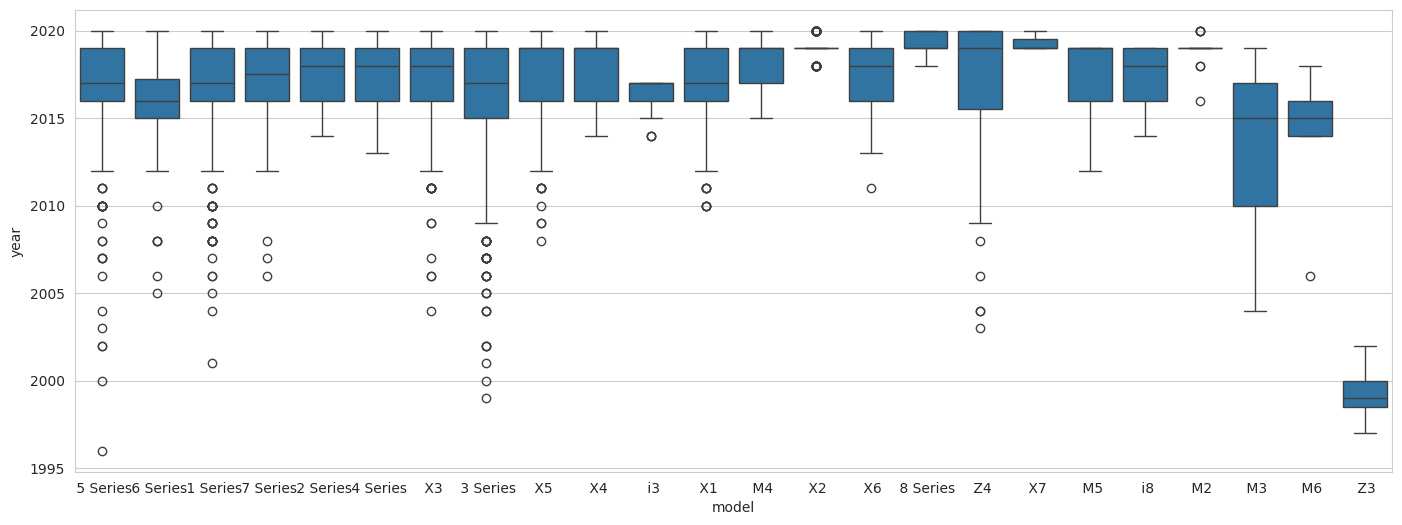

In [18]:
plt.figure(figsize=(17, 6))
sns.boxplot(x=df['model'], y=df['year'])
plt.show()

The boxplot of year vs model shows that the majority of observations across most BMW models fall between 2015 and 2020, with a higher concentration specifically between 2016 and 2019, indicating that the dataset is dominated by vehicles from recent production years.